#[Super SloMo](https://people.cs.umass.edu/~hzjiang/projects/superslomo/)
##High Quality Estimation of Multiple Intermediate Frames for Video Interpolation


In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import model
import dataloader
import matplotlib.pyplot as plt
from math import log10
from IPython.display import clear_output, display
import datetime
from tensorboardX import SummaryWriter

##Parameters

In [2]:
# Learning Rate. Set `MILESTONES` to epoch values where you want to decrease
# learning rate by a factor of 0.1
INITIAL_LEARNING_RATE = 0.0001
MILESTONES = [100, 150]

# Number of epochs to train
EPOCHS = 200

# Choose batchsize as per GPU/CPU configuration
# This configuration works on GTX 1080 Ti
TRAIN_BATCH_SIZE = 6
VALIDATION_BATCH_SIZE = 10

# Path to dataset folder containing train-test-validation folders
DATASET_ROOT = "/home/rajivratn/datasets/multimodal_inpainting/adobe240_processed"

# Path to folder for saving checkpoints
CHECKPOINT_DIR = '/home/rajivratn/devansh/Super-SloMo/checkpoints'

# If resuming from checkpoint, set `trainingContinue` to True and set `checkpoint_path`
TRAINING_CONTINUE = False
CHECKPOINT_PATH = 'path/to/checkpoint/file'

# Progress and validation frequency (N: after every N iterations)
PROGRESS_ITER = 100

# Checkpoint frequency (N: after every N epochs). Each checkpoint is roughly of size 151 MB.
CHECKPOINT_EPOCH = 5

##[TensorboardX](https://github.com/lanpa/tensorboardX)
### For visualizing loss and interpolated frames

In [3]:
writer = SummaryWriter('log')

###Initialize flow computation and arbitrary-time flow interpolation CNNs.

In [11]:
device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")
flowComp = model.UNet(6, 4)
flowComp.to(device)
ArbTimeFlowIntrp = model.UNet(20, 5)
ArbTimeFlowIntrp.to(device)
# import os
# print(os.environ["CUDA_DEVICE_ORDER"])  
# torch.cuda.get_device_name(9)


UNet(
  (conv1): Conv2d(20, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (down1): down(
    (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (down2): down(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down3): down(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down4): down(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down5): down(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Co

###Initialze backward warpers for train and validation datasets

In [12]:
trainFlowBackWarp      = model.backWarp(352, 352, device)
trainFlowBackWarp      = trainFlowBackWarp.to(device)
validationFlowBackWarp = model.backWarp(640, 352, device)
validationFlowBackWarp = validationFlowBackWarp.to(device)

###Load Datasets

In [13]:
# Channel wise mean calculated on adobe240-fps training dataset
mean = [0.429, 0.431, 0.397]
std  = [1, 1, 1]
normalize = transforms.Normalize(mean=mean,
                                 std=std)
transform = transforms.Compose([transforms.ToTensor(), normalize])

trainset = dataloader.SuperSloMo(root=DATASET_ROOT + '/train', transform=transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

validationset = dataloader.SuperSloMo(root=DATASET_ROOT + '/validation', transform=transform, randomCropSize=(640, 352), train=False)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=VALIDATION_BATCH_SIZE, shuffle=False)

print(trainset, validationset)

Dataset SuperSloMo
    Number of datapoints: 7342
    Root Location: /home/rajivratn/datasets/multimodal_inpainting/adobe240_processed/train
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.429, 0.431, 0.397], std=[1, 1, 1])
                         )
 Dataset SuperSloMo
    Number of datapoints: 100
    Root Location: /home/rajivratn/datasets/multimodal_inpainting/adobe240_processed/validation
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.429, 0.431, 0.397], std=[1, 1, 1])
                         )



###Create transform to display image from tensor

In [14]:
negmean = [x * -1 for x in mean]
revNormalize = transforms.Normalize(mean=negmean, std=std)
TP = transforms.Compose([revNormalize, transforms.ToPILImage()])

###Test the dataset

Intermediate frame index:  tensor(2)


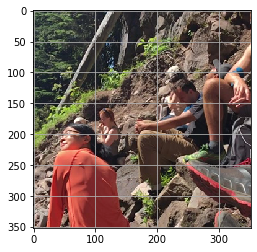

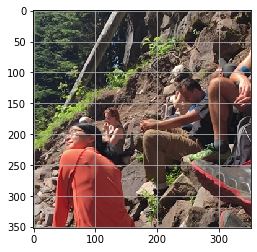

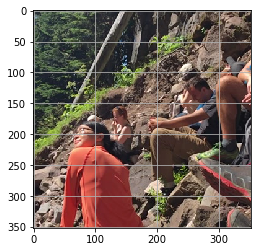

In [15]:
for trainIndex, (trainData, frameIndex) in enumerate(trainloader, 0):
    frame0, frameT, frame1 = trainData
    print("Intermediate frame index: ", (frameIndex[0]))
    plt.imshow(TP(frame0[0]))
    plt.grid(True)
    plt.figure()
    plt.imshow(TP(frameT[0]))
    plt.grid(True)
    plt.figure()
    plt.imshow(TP(frame1[0]))
    plt.grid(True)
    break

###Utils

In [16]:
plt.rcParams['figure.figsize'] = [15, 3]
def Plot(num, listInp, d):
    a = listInp
    c = []
    for b in a:
        c.append(sum(b)/len(b))
    plt.subplot(1, 2, num)
    plt.plot(c, color=d)
    plt.grid(True)
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

###Loss and Optimizer

In [17]:
L1_lossFn = nn.L1Loss()
MSE_LossFn = nn.MSELoss()

params = list(ArbTimeFlowIntrp.parameters()) + list(flowComp.parameters())

optimizer = optim.Adam(params, lr=INITIAL_LEARNING_RATE)
# scheduler to decrease learning rate by a factor of 10 at milestones.
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)

###Initializing VGG16 model for perceptual loss

In [18]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16_conv_4_3 = nn.Sequential(*list(vgg16.children())[0][:22])
vgg16_conv_4_3.to(device)
for param in vgg16_conv_4_3.parameters():
		param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/rajivratn/.cache/torch/checkpoints/vgg16-397923af.pth
100.0%


### Validation function


In [19]:
def validate():
    # For details see training.
    psnr = 0
    tloss = 0
    flag = 1
    with torch.no_grad():
        for validationIndex, (validationData, validationFrameIndex) in enumerate(validationloader, 0):
            frame0, frameT, frame1 = validationData

            I0 = frame0.to(device)
            I1 = frame1.to(device)
            IFrame = frameT.to(device)
                        
            
            flowOut = flowComp(torch.cat((I0, I1), dim=1))
            F_0_1 = flowOut[:,:2,:,:]
            F_1_0 = flowOut[:,2:,:,:]

            fCoeff = model.getFlowCoeff(validationFrameIndex, device)

            F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
            F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0

            g_I0_F_t_0 = validationFlowBackWarp(I0, F_t_0)
            g_I1_F_t_1 = validationFlowBackWarp(I1, F_t_1)
            
            intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))
                
            F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
            F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
            V_t_0   = F.sigmoid(intrpOut[:, 4:5, :, :])
            V_t_1   = 1 - V_t_0
                
            g_I0_F_t_0_f = validationFlowBackWarp(I0, F_t_0_f)
            g_I1_F_t_1_f = validationFlowBackWarp(I1, F_t_1_f)
            
            wCoeff = model.getWarpCoeff(validationFrameIndex, device)
            
            Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)
            
            # For tensorboard
            if (flag):
                retImg = torchvision.utils.make_grid([revNormalize(frame0[0]), revNormalize(frameT[0]), revNormalize(Ft_p.cpu()[0]), revNormalize(frame1[0])], padding=10)
                flag = 0
            
            
            #loss
            recnLoss = L1_lossFn(Ft_p, IFrame)
            
            prcpLoss = MSE_LossFn(vgg16_conv_4_3(Ft_p), vgg16_conv_4_3(IFrame))
            
            warpLoss = L1_lossFn(g_I0_F_t_0, IFrame) + L1_lossFn(g_I1_F_t_1, IFrame) + L1_lossFn(validationFlowBackWarp(I0, F_1_0), I1) + L1_lossFn(validationFlowBackWarp(I1, F_0_1), I0)
        
            loss_smooth_1_0 = torch.mean(torch.abs(F_1_0[:, :, :, :-1] - F_1_0[:, :, :, 1:])) + torch.mean(torch.abs(F_1_0[:, :, :-1, :] - F_1_0[:, :, 1:, :]))
            loss_smooth_0_1 = torch.mean(torch.abs(F_0_1[:, :, :, :-1] - F_0_1[:, :, :, 1:])) + torch.mean(torch.abs(F_0_1[:, :, :-1, :] - F_0_1[:, :, 1:, :]))
            loss_smooth = loss_smooth_1_0 + loss_smooth_0_1
            
            
            loss = 204 * recnLoss + 102 * warpLoss + 0.005 * prcpLoss + loss_smooth
            tloss += loss.item()
            
            #psnr
            MSE_val = MSE_LossFn(Ft_p, IFrame)
            psnr += (10 * log10(1 / MSE_val.item()))
            
    return (psnr / len(validationloader)), (tloss / len(validationloader)), retImg

### Test validation

/home/rajivratn/miniconda3/envs/dbpy36/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/rajivratn/miniconda3/envs/dbpy36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/rajivratn/miniconda3/envs/dbpy36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is depr

22.930717048967814 33.06061191558838 torch.Size([3, 372, 2610])


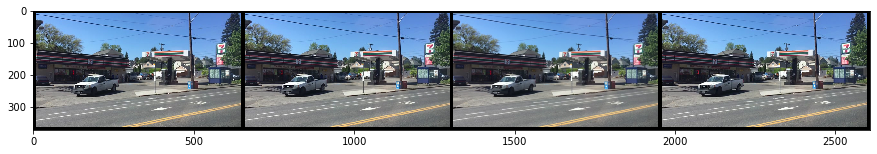

In [20]:
a, b, c = validate()
print(a, b, c.size())
plt.imshow(c.permute(1, 2, 0).numpy())

### Initialization

In [21]:
if TRAINING_CONTINUE:
    dict1 = torch.load(CHECKPOINT_PATH)
    ArbTimeFlowIntrp.load_state_dict(dict1['state_dictAT'])
    flowComp.load_state_dict(dict1['state_dictFC'])
else:
    dict1 = {'loss': [], 'valLoss': [], 'valPSNR': [], 'epoch': -1}

### Training

Epoch:  74


/home/rajivratn/miniconda3/envs/dbpy36/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


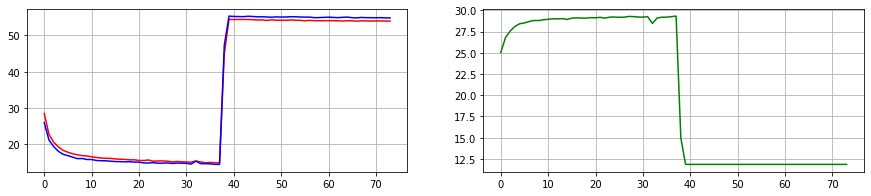

/home/rajivratn/miniconda3/envs/dbpy36/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/rajivratn/miniconda3/envs/dbpy36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/rajivratn/miniconda3/envs/dbpy36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is depr

 Loss: 54.208117  Iterations:   99/1224  TrainExecTime: 79.9  ValLoss:54.993565  ValPSNR: 11.8551  ValEvalTime: 8.21 LearningRate: 0.000100
 Loss: 53.555225  Iterations:  199/1224  TrainExecTime: 63.6  ValLoss:54.769785  ValPSNR: 11.8551  ValEvalTime: 8.69 LearningRate: 0.000100
 Loss: 53.932190  Iterations:  299/1224  TrainExecTime: 63.1  ValLoss:54.773104  ValPSNR: 11.8551  ValEvalTime: 8.45 LearningRate: 0.000100
 Loss: 53.770209  Iterations:  399/1224  TrainExecTime: 63.5  ValLoss:54.816294  ValPSNR: 11.8551  ValEvalTime: 8.53 LearningRate: 0.000100
 Loss: 54.339677  Iterations:  499/1224  TrainExecTime: 64.4  ValLoss:55.395899  ValPSNR: 11.8551  ValEvalTime: 8.54 LearningRate: 0.000100
 Loss: 53.632522  Iterations:  599/1224  TrainExecTime: 62.3  ValLoss:54.729141  ValPSNR: 11.8551  ValEvalTime: 8.21 LearningRate: 0.000100
 Loss: 53.620829  Iterations:  699/1224  TrainExecTime: 63.9  ValLoss:54.684610  ValPSNR: 11.8551  ValEvalTime: 8.47 LearningRate: 0.000100
 Loss: 53.829777  It

In [ ]:
import time

start = time.time()
cLoss   = dict1['loss']
valLoss = dict1['valLoss']
valPSNR = dict1['valPSNR']
checkpoint_counter = 0

### Main training loop
for epoch in range(dict1['epoch'] + 1, EPOCHS):
    clear_output()
    print("Epoch: ", epoch)
    
    # Plots
    if (epoch):
        Plot(1, cLoss, 'red')
        Plot(1, valLoss, 'blue')
        Plot(2, valPSNR, 'green')
        display(plt.gcf())
    
    # Append and reset
    cLoss.append([])
    valLoss.append([])
    valPSNR.append([])
    iLoss = 0
    
    # Increment scheduler count    
    scheduler.step()
    
    for trainIndex, (trainData, trainFrameIndex) in enumerate(trainloader, 0):
        
		## Getting the input and the target from the training set
        frame0, frameT, frame1 = trainData
        
        I0 = frame0.to(device)
        I1 = frame1.to(device)
        IFrame = frameT.to(device)
        
        optimizer.zero_grad()
        
        # Calculate flow between reference frames I0 and I1
        flowOut = flowComp(torch.cat((I0, I1), dim=1))
        
        # Extracting flows between I0 and I1 - F_0_1 and F_1_0
        F_0_1 = flowOut[:,:2,:,:]
        F_1_0 = flowOut[:,2:,:,:]
        
        fCoeff = model.getFlowCoeff(trainFrameIndex, device)
        
        # Calculate intermediate flows
        F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
        F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0
        
        # Get intermediate frames from the intermediate flows
        g_I0_F_t_0 = trainFlowBackWarp(I0, F_t_0)
        g_I1_F_t_1 = trainFlowBackWarp(I1, F_t_1)
        
        # Calculate optical flow residuals and visibility maps
        intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))
        
        # Extract optical flow residuals and visibility maps
        F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
        F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
        V_t_0   = F.sigmoid(intrpOut[:, 4:5, :, :])
        V_t_1   = 1 - V_t_0
        
        # Get intermediate frames from the intermediate flows
        g_I0_F_t_0_f = trainFlowBackWarp(I0, F_t_0_f)
        g_I1_F_t_1_f = trainFlowBackWarp(I1, F_t_1_f)
        
        wCoeff = model.getWarpCoeff(trainFrameIndex, device)
        
        # Calculate final intermediate frame 
        Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)
        
        # Loss
        recnLoss = L1_lossFn(Ft_p, IFrame)
            
        prcpLoss = MSE_LossFn(vgg16_conv_4_3(Ft_p), vgg16_conv_4_3(IFrame))
        
        warpLoss = L1_lossFn(g_I0_F_t_0, IFrame) + L1_lossFn(g_I1_F_t_1, IFrame) + L1_lossFn(trainFlowBackWarp(I0, F_1_0), I1) + L1_lossFn(trainFlowBackWarp(I1, F_0_1), I0)
        
        loss_smooth_1_0 = torch.mean(torch.abs(F_1_0[:, :, :, :-1] - F_1_0[:, :, :, 1:])) + torch.mean(torch.abs(F_1_0[:, :, :-1, :] - F_1_0[:, :, 1:, :]))
        loss_smooth_0_1 = torch.mean(torch.abs(F_0_1[:, :, :, :-1] - F_0_1[:, :, :, 1:])) + torch.mean(torch.abs(F_0_1[:, :, :-1, :] - F_0_1[:, :, 1:, :]))
        loss_smooth = loss_smooth_1_0 + loss_smooth_0_1
          
        # Total Loss - Coefficients 204 and 102 are used instead of 0.8 and 0.4
        # since the loss in paper is calculated for input pixels in range 0-255
        # and the input to our network is in range 0-1
        loss = 204 * recnLoss + 102 * warpLoss + 0.005 * prcpLoss + loss_smooth
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        iLoss += loss.item()
               
        # Validation and progress every `PROGRESS_ITER` iterations
        if ((trainIndex % PROGRESS_ITER) == PROGRESS_ITER - 1):
            end = time.time()
            
            psnr, vLoss, valImg = validate()
            
            valPSNR[epoch].append(psnr)
            valLoss[epoch].append(vLoss)
            
            #Tensorboard
            itr = trainIndex + epoch * (len(trainloader))
            
            writer.add_scalars('Loss', {'trainLoss': iLoss/PROGRESS_ITER,
                                        'validationLoss': vLoss}, itr)
            writer.add_scalar('PSNR', psnr, itr)
            
            writer.add_image('Validation',valImg , itr)
            #####
            
            endVal = time.time()
            
            print(" Loss: %0.6f  Iterations: %4d/%4d  TrainExecTime: %0.1f  ValLoss:%0.6f  ValPSNR: %0.4f  ValEvalTime: %0.2f LearningRate: %f" % (iLoss / PROGRESS_ITER, trainIndex, len(trainloader), end - start, vLoss, psnr, endVal - end, get_lr(optimizer)))
            
            
            cLoss[epoch].append(iLoss/PROGRESS_ITER)
            iLoss = 0
            start = time.time()
    
    # Create checkpoint after every `CHECKPOINT_EPOCH` epochs
    if ((epoch % CHECKPOINT_EPOCH) == CHECKPOINT_EPOCH - 1):
        dict1 = {
                'Detail':"End to end Super SloMo.",
                'epoch':epoch,
                'timestamp':datetime.datetime.now(),
                'trainBatchSz':TRAIN_BATCH_SIZE,
                'validationBatchSz':VALIDATION_BATCH_SIZE,
                'learningRate':get_lr(optimizer),
                'loss':cLoss,
                'valLoss':valLoss,
                'valPSNR':valPSNR,
                'state_dictFC': flowComp.state_dict(),
                'state_dictAT': ArbTimeFlowIntrp.state_dict(),
                }
        torch.save(dict1, CHECKPOINT_DIR + "/SuperSloMo" + str(checkpoint_counter) + ".ckpt")
        checkpoint_counter += 1
    plt.close('all')